# Project - Film Junky Union

## Table of Contents

* [Project Statement](#Project_Statement)
* [Data description](#Data_description)
* [Initialization](#Initialization)
* [Load the data](#Load)
* [EDA](#EDA)
* [Normalization](#Normalization)
* [Train / Test Split](#Split)
* [Working with models](#models)
* [My Reviews](#Reviews)
* [Conclusion](#Conclusion)

# Project Statement<a class="anchor" id="Project_Statement"></a>

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Data description<a class="anchor" id="Data_description"></a>

The data was provided by Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).
* review: the review text
* pos: the target, '0' for negative and '1' for positive
* ds_part: 'train'/'test' for the train/test part of dataset, correspondingly

## Initialization<a class="anchor" id="Initialization"></a>

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer 

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from numpy.random import RandomState
import warnings
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from statistics import mean
import catboost as cb
from sklearn.preprocessing import OrdinalEncoder
from catboost import Pool, cv
import math
import lightgbm as lgb
import xgboost as xgb
import re
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data<a class="anchor" id="Load"></a>

In [4]:
df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [6]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [7]:
report = df_reviews.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / df_reviews.shape[0]).round(2)
report.sort_values(by = 'missing_values', ascending = False).style.background_gradient('coolwarm')

,missing_values,% of total
average_rating,2,0.000000
votes,2,0.000000
tconst,0,0.000000
ds_part,0,0.000000
pos,0,0.000000
sp,0,0.000000
rating,0,0.000000
review,0,0.000000
genres,0,0.000000
title_type,0,0.000000


In [8]:
print("duplicates number: {}".format(df_reviews.duplicated().sum()))

duplicates number: 0


In [9]:
df_reviews =df_reviews.dropna()

In [10]:
report = df_reviews.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / df_reviews.shape[0]).round(2)
report.sort_values(by = 'missing_values', ascending = False).style.background_gradient('coolwarm')

,missing_values,% of total
tconst,0,0.000000
average_rating,0,0.000000
ds_part,0,0.000000
pos,0,0.000000
sp,0,0.000000
rating,0,0.000000
review,0,0.000000
votes,0,0.000000
genres,0,0.000000
title_type,0,0.000000


## EDA<a class="anchor" id="EDA"></a>

Let's check the number of movies and reviews over years.

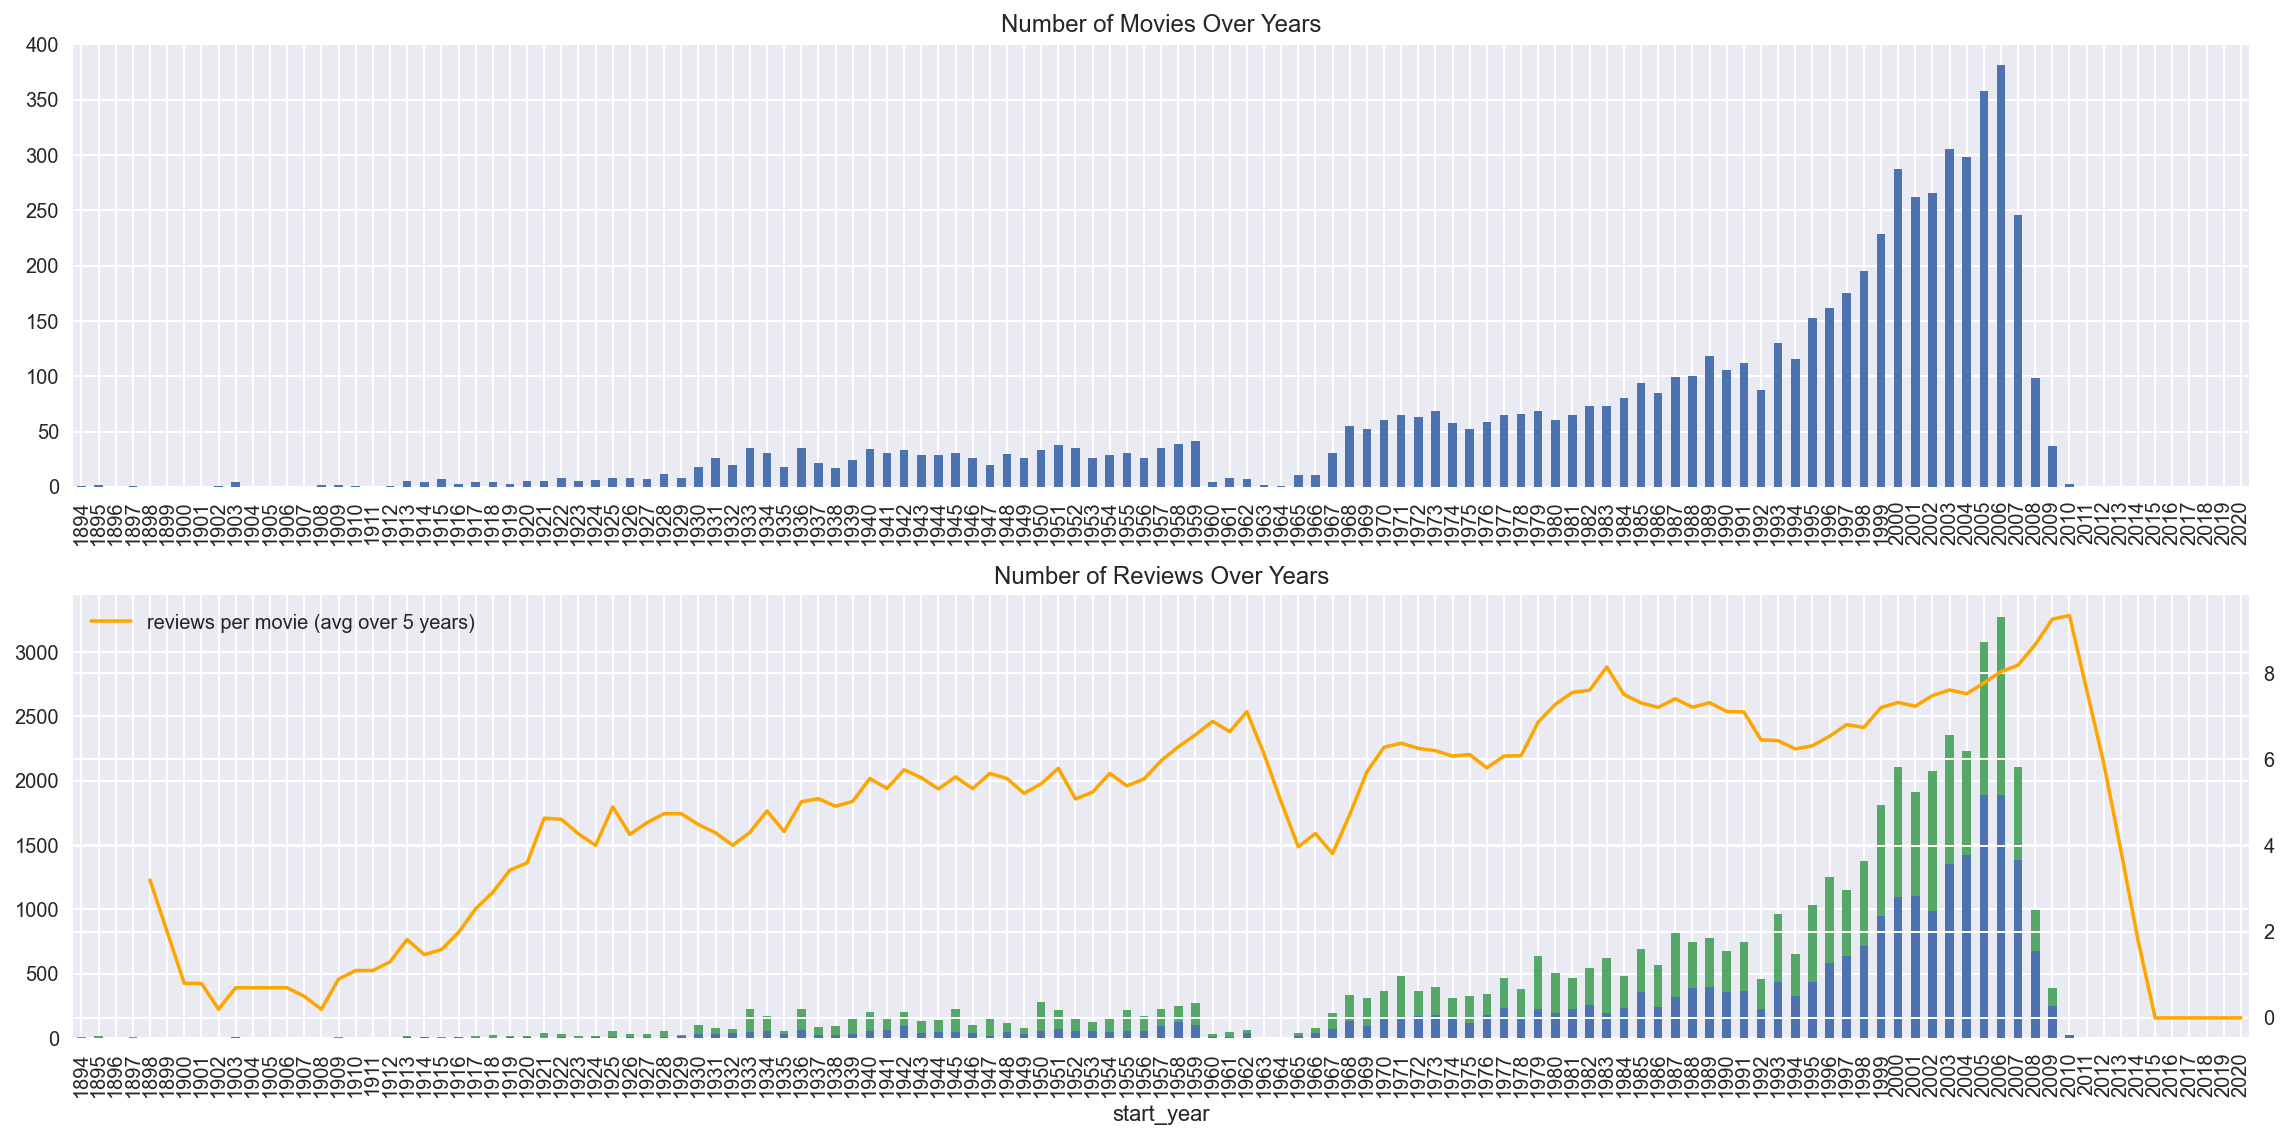

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

<div style="border:solid black 2px; padding: 20px"> <b>Note:</b><br>
There seem to be more reviews of movies and more movies as the years' progressed till 2007, meaning the number of reviews and amount of movies is correlated. 2007 had the financial crisis and it seemed to affect the production of movies 3 years later.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

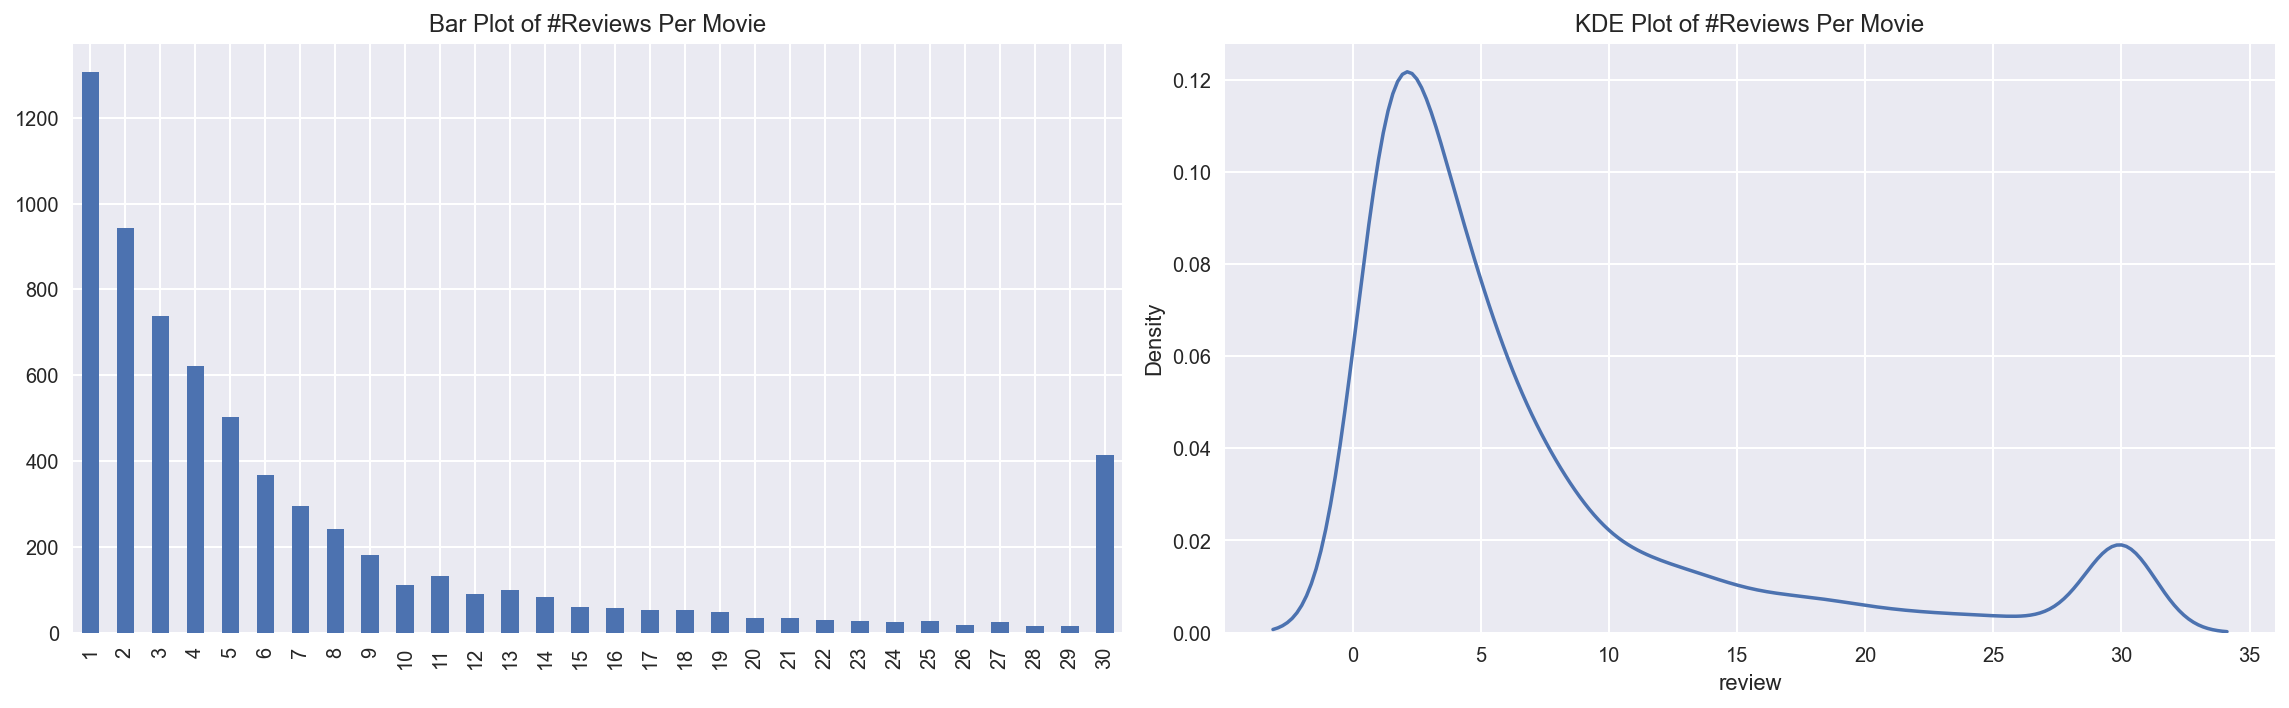

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [13]:
bm = df_reviews.groupby(['tconst','rating'])['review'].count().reset_index()
bm = bm.sort_values('review',ascending=False)
bm.head(40)

,tconst,rating,review
16874,tt0472047,1,30
16679,tt0463392,1,30
3304,tt0071075,10,30
16363,tt0451109,1,28
4866,tt0085474,10,27
5816,tt0093142,1,26
10607,tt0184424,10,26
13228,tt0312528,1,26
13351,tt0317676,1,25
10925,tt0201290,1,25


<div style="border:solid black 2px; padding: 20px"> <b>Note:</b><br>
Their distribution of reviews per movie seems logical, there is more of one review per movie than 12 reviews per movie. but the outlier - 30 reviews per movie might come from movies that are highly esteemed or the movie was really bad. people tend to rate in either high or very bad - 1 or 10 as we can see in the table above. 

In [15]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

<div style="border:solid black 2px; padding: 20px"> <b>Note:</b><br>
The target is balanced

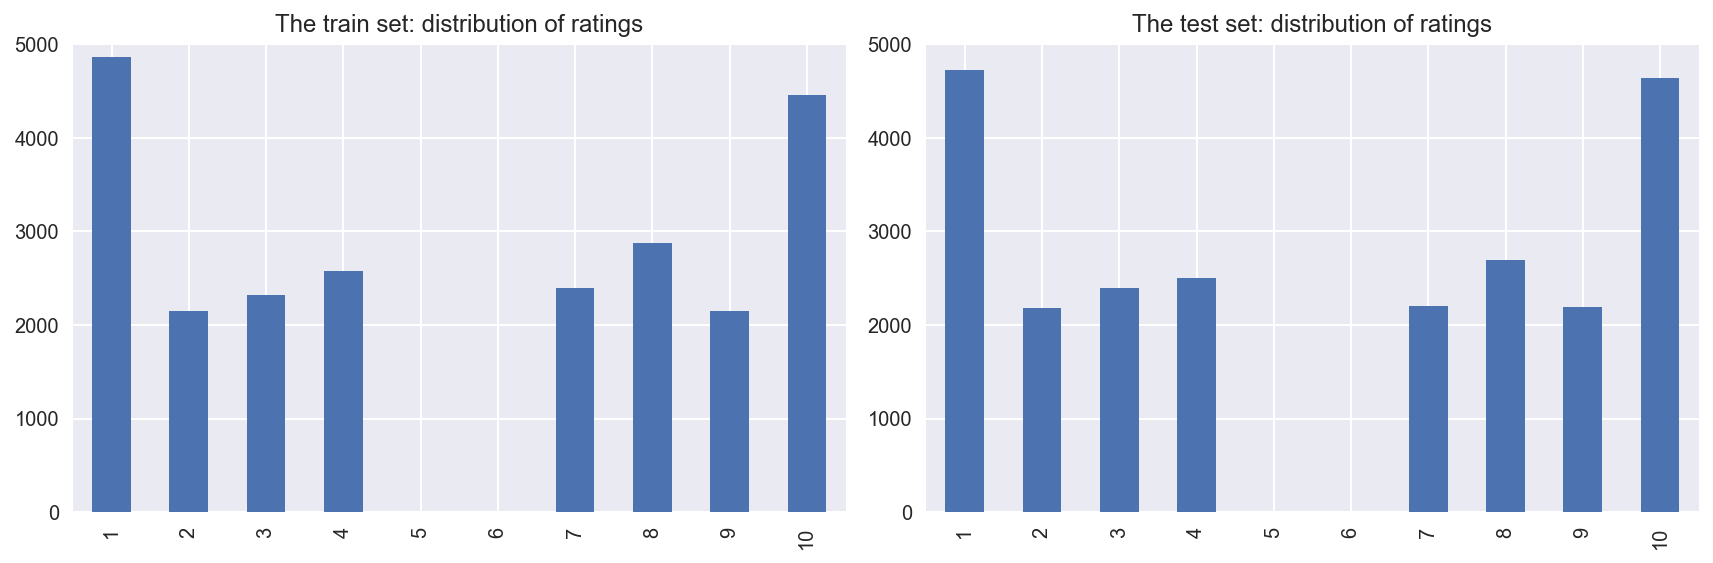

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

<div style="border:solid black 2px; padding: 20px"> <b>Note:</b>
The distributions of ratings is similar in both the training set and the test set. as mentioned before, most of the reviews will be either bad - 4 and lower and good -7 and higher, people tend to rate either nad or good but not a lot of ratings will be in the middle. <br>

Distribution of negative and positive reviews over the years for two parts of the dataset

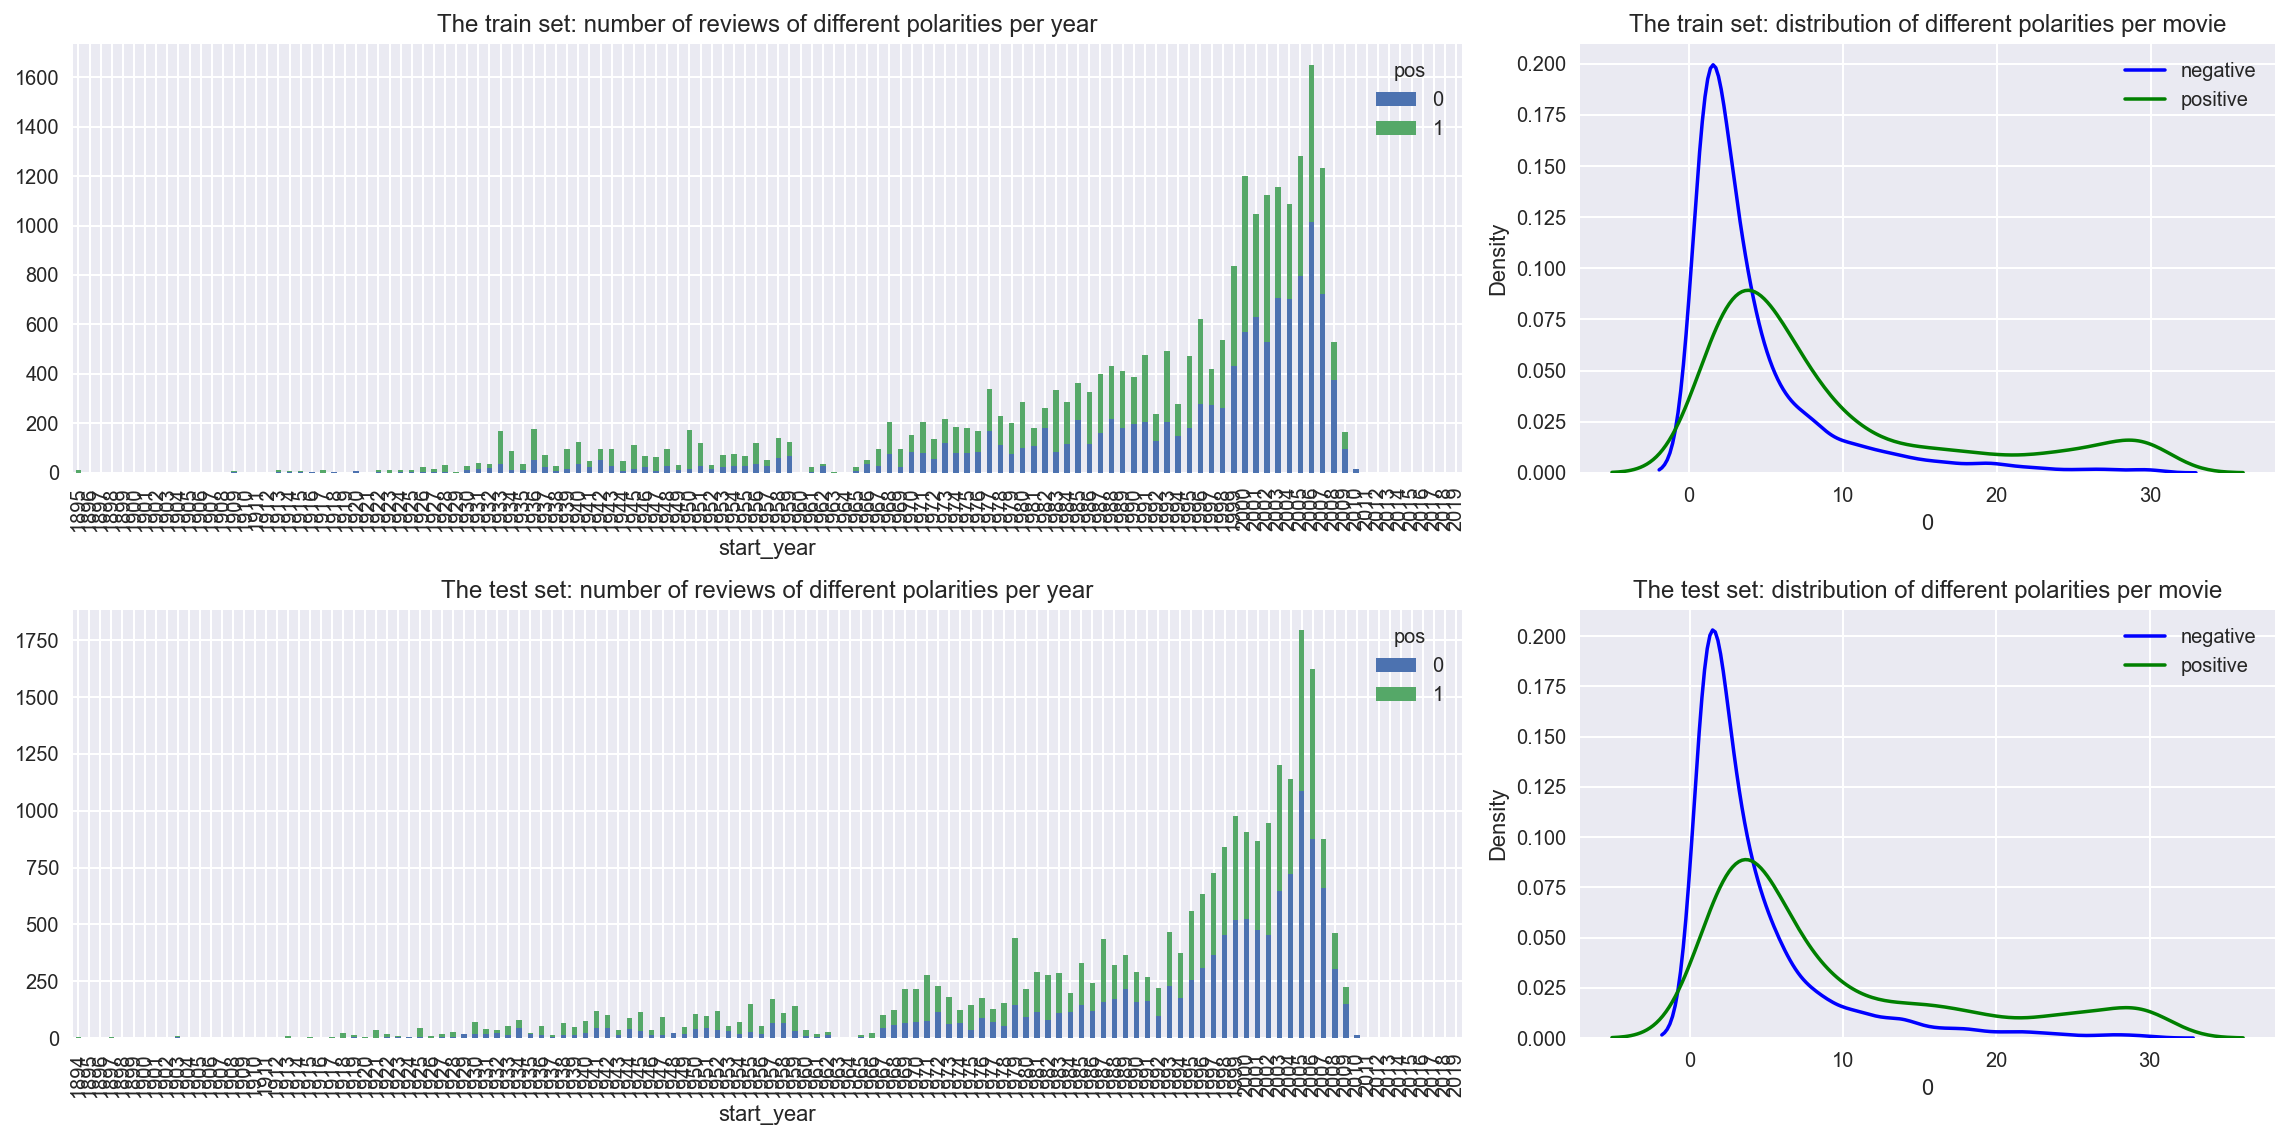

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

<div style="border:solid black 2px; padding: 20px"> <b>Note:</b>
It seems the reviews - either positive or negative are balanced per year and are distributed the same for both the training and the test sets. there are more reviews for newer movies, but this is logical, as the newer movies are reviewed by more viewers than old movies. 

## Evaluation Procedure<a class="anchor" id="Evaluation"></a>

Composing an evaluation routine which can be used for all models in this project

In [18]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization<a class="anchor" id="Normalization"></a>

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [19]:
def clear_text(text):
    
    # < write code here >

    pattern = r"[^a-zA-Z]"
    text = re.sub(pattern, " ", text)
    text = text.split()
    text = " ".join(text)
    text = text.lower()
    return text 


In [20]:
df_reviews['review_norm'] =df_reviews['review'].apply(clear_text)

In [21]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,review_norm
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335,the pakage implies that warren beatty and gold...
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336,how the hell did they get this made presenting...
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489,there is no real story the film seems more lik...
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280,um a serious film about troubled teens in sing...
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281,i m totally agree with garryjohal from singapo...


In [22]:
print(df_reviews['review_norm'].sample(5))

666      this is a great film the first time i saw it i...
27835    this is the true story of the great pianist an...
30259    when its dvd was released i came to market and...
10863    my guess is that the producers of this low bud...
9156     darling lili is fantastic its by far one my fa...
Name: review_norm, dtype: object


## Train / Test Split <a class="anchor" id="Split"></a> 

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [23]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


In [24]:
train_features = df_reviews_train['review_norm']
test_features  = df_reviews_test['review_norm']

In [25]:
print(train_features.shape)
print(train_features.shape)

(23796,)
(23796,)


In [26]:
print(train_target.shape)
print(test_target.shape)

(23796,)
(23533,)


## Working with models <a class="anchor" id="models"></a> 

### Model 0 - Constant

In [27]:
from sklearn.dummy import DummyClassifier

In [28]:
model_0 = DummyClassifier(strategy="constant", random_state=12345, constant=[0])

In [29]:
model_0.fit(train_features, train_target)

DummyClassifier(constant=[0], random_state=12345, strategy='constant')

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


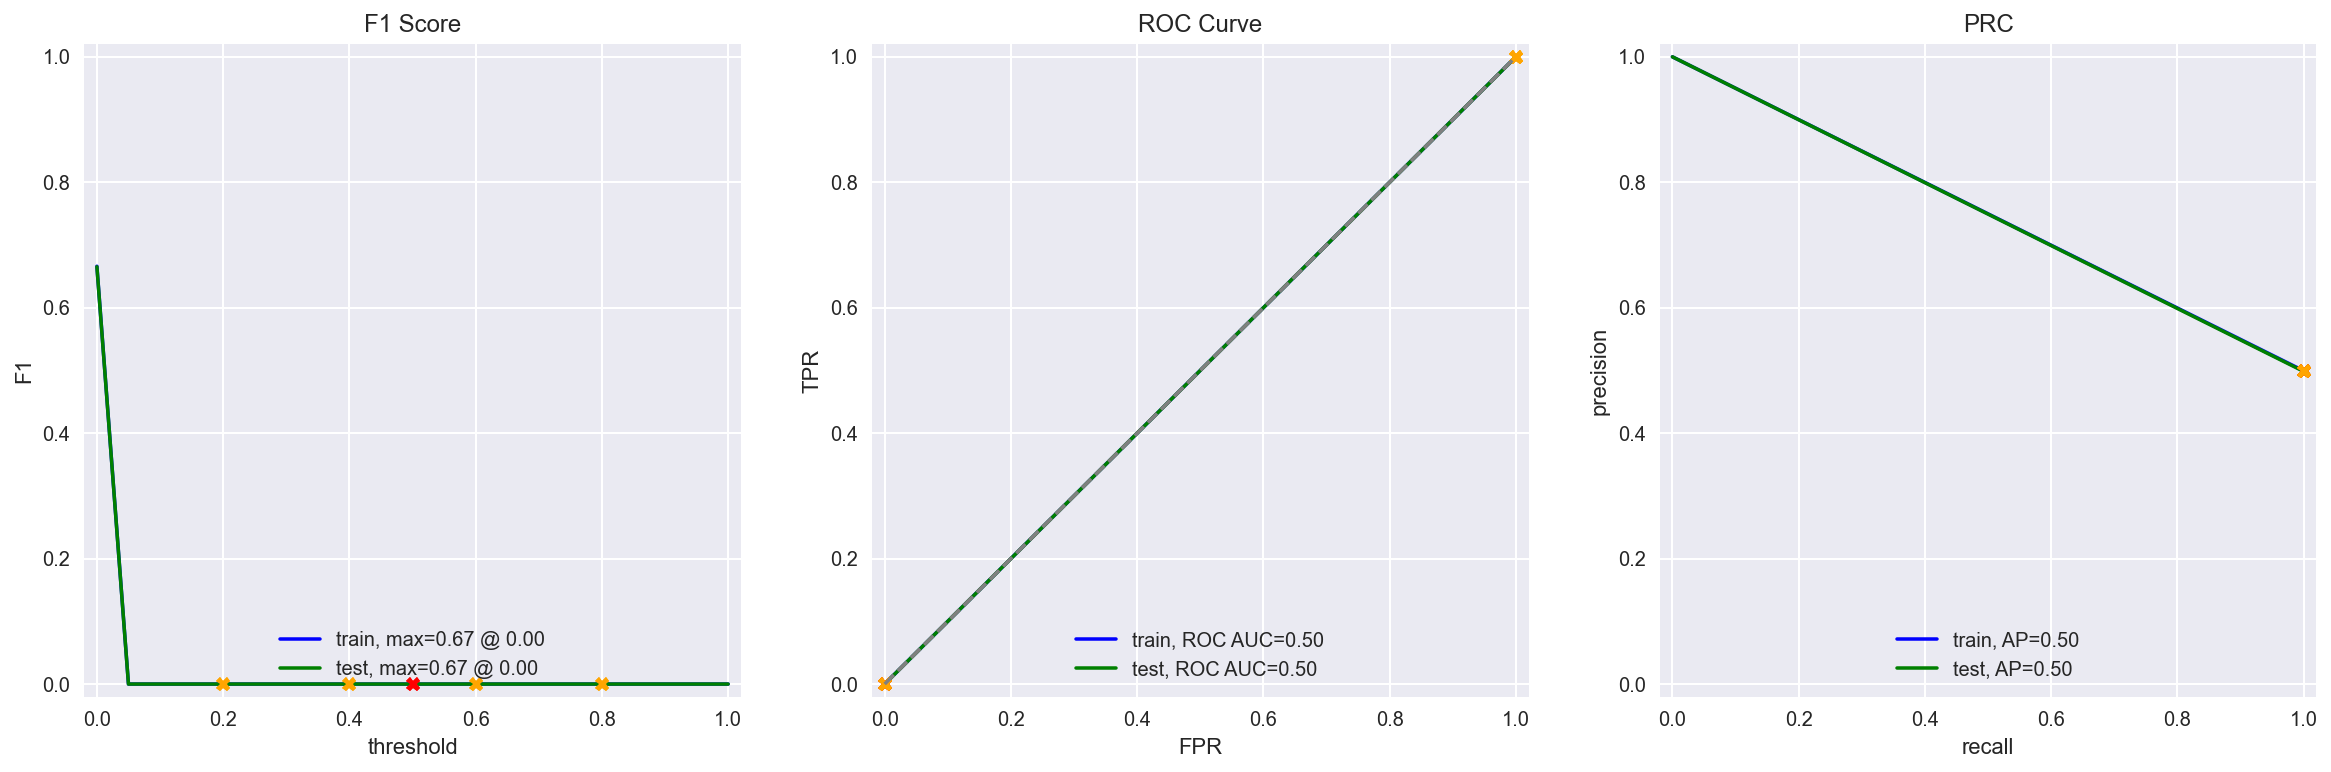

In [30]:
evaluate_model(model_0, train_features, train_target, test_features, test_target)

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [31]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [167]:
nltk.download('stopwords') 
stop_words = set(stopwords.words('english')) 
count_vect = CountVectorizer(stop_words=stop_words) 
corpus_train = train_features

count_tf_idf = TfidfVectorizer(stop_words=stop_words) 

tf_idf_train = count_tf_idf.fit_transform(corpus_train) 


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yaniv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:

tf_idf_test = count_tf_idf.transform(test_features) 


In [34]:
print(tf_idf_train.shape)
print(tf_idf_test.shape)

(23796, 71531)
(23533, 71531)


In [35]:
model_1 = LogisticRegression(solver='liblinear',random_state=12345)

model_1.fit(tf_idf_train, train_target)


LogisticRegression(random_state=12345, solver='liblinear')

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


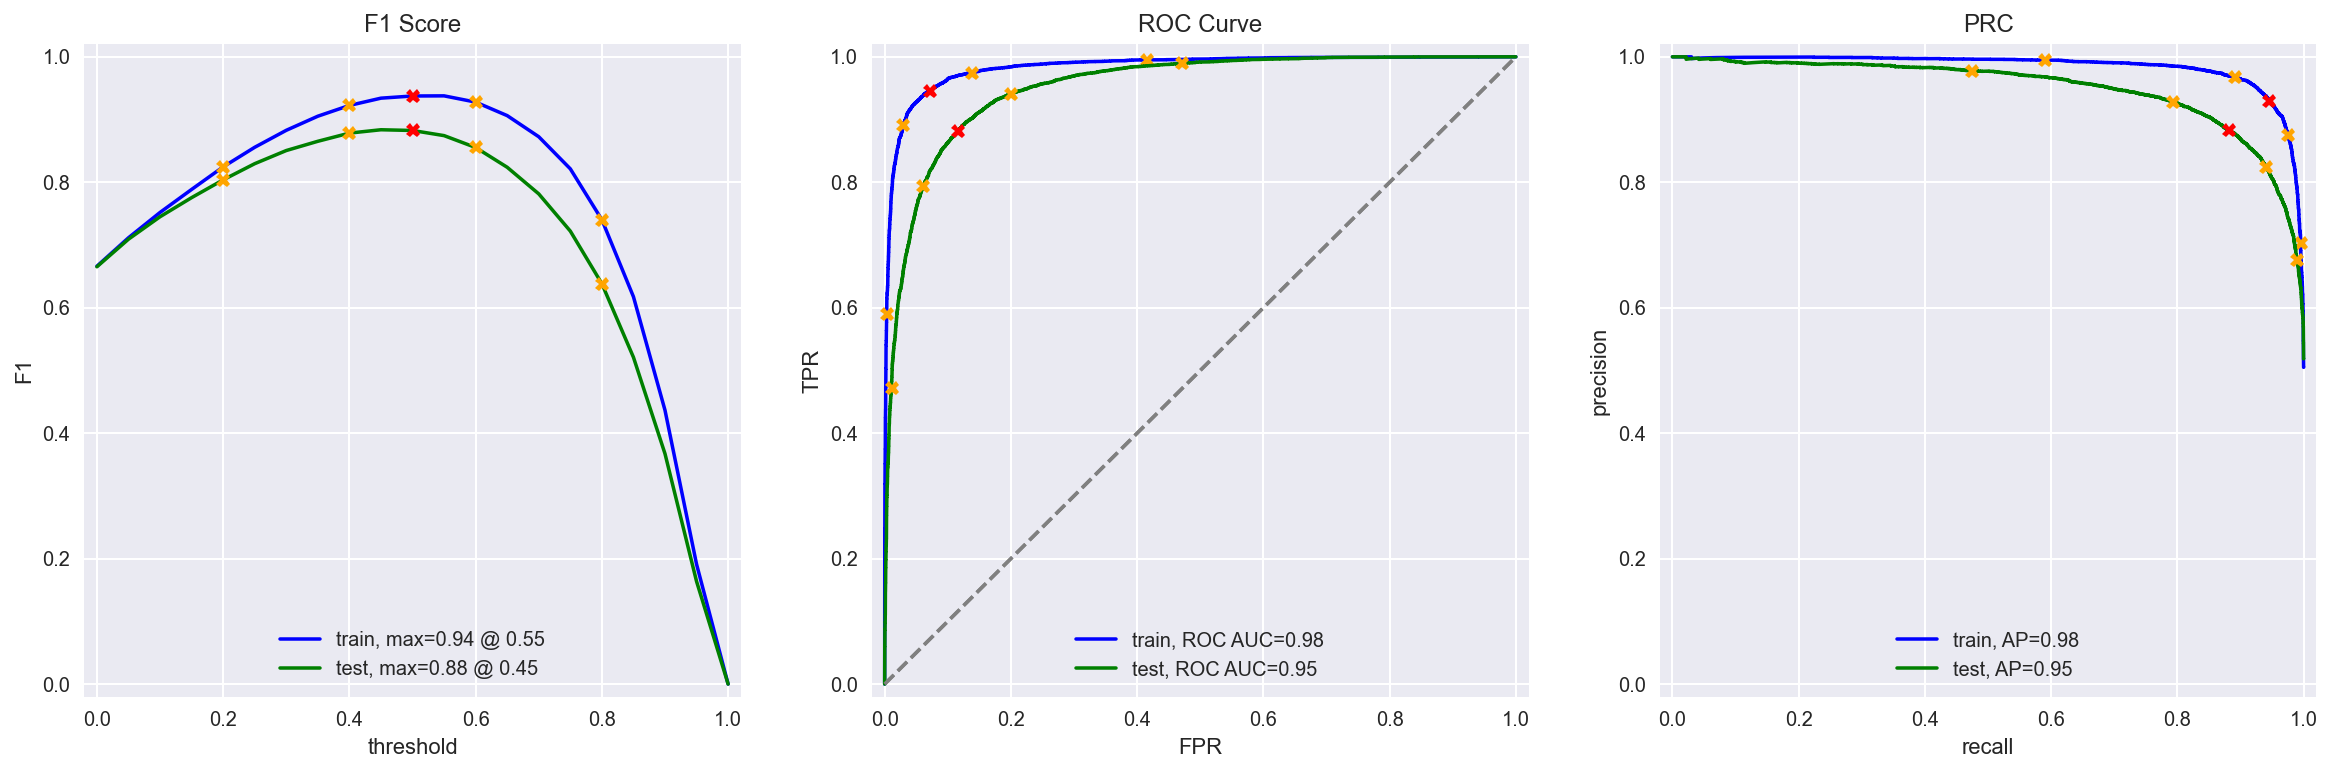

In [36]:
evaluate_model(model_1, tf_idf_train, train_target, tf_idf_test, test_target)

### Model 3 - spaCy, TF-IDF and LR

In [37]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [38]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [39]:
corpus_train_nlp = train_features.apply(text_preprocessing_3)

In [41]:
corpus_test_nlp = test_features.apply(text_preprocessing_3)

In [181]:
tf_idf_train_nlp = count_tf_idf.fit_transform(corpus_train_nlp)

In [42]:
tf_idf_test_nlp =count_tf_idf.transform(corpus_test_nlp)

In [43]:
model_2 = LogisticRegression(solver='liblinear',random_state=12345)

model_2.fit(tf_idf_train_nlp, train_target)

LogisticRegression(random_state=12345, solver='liblinear')

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


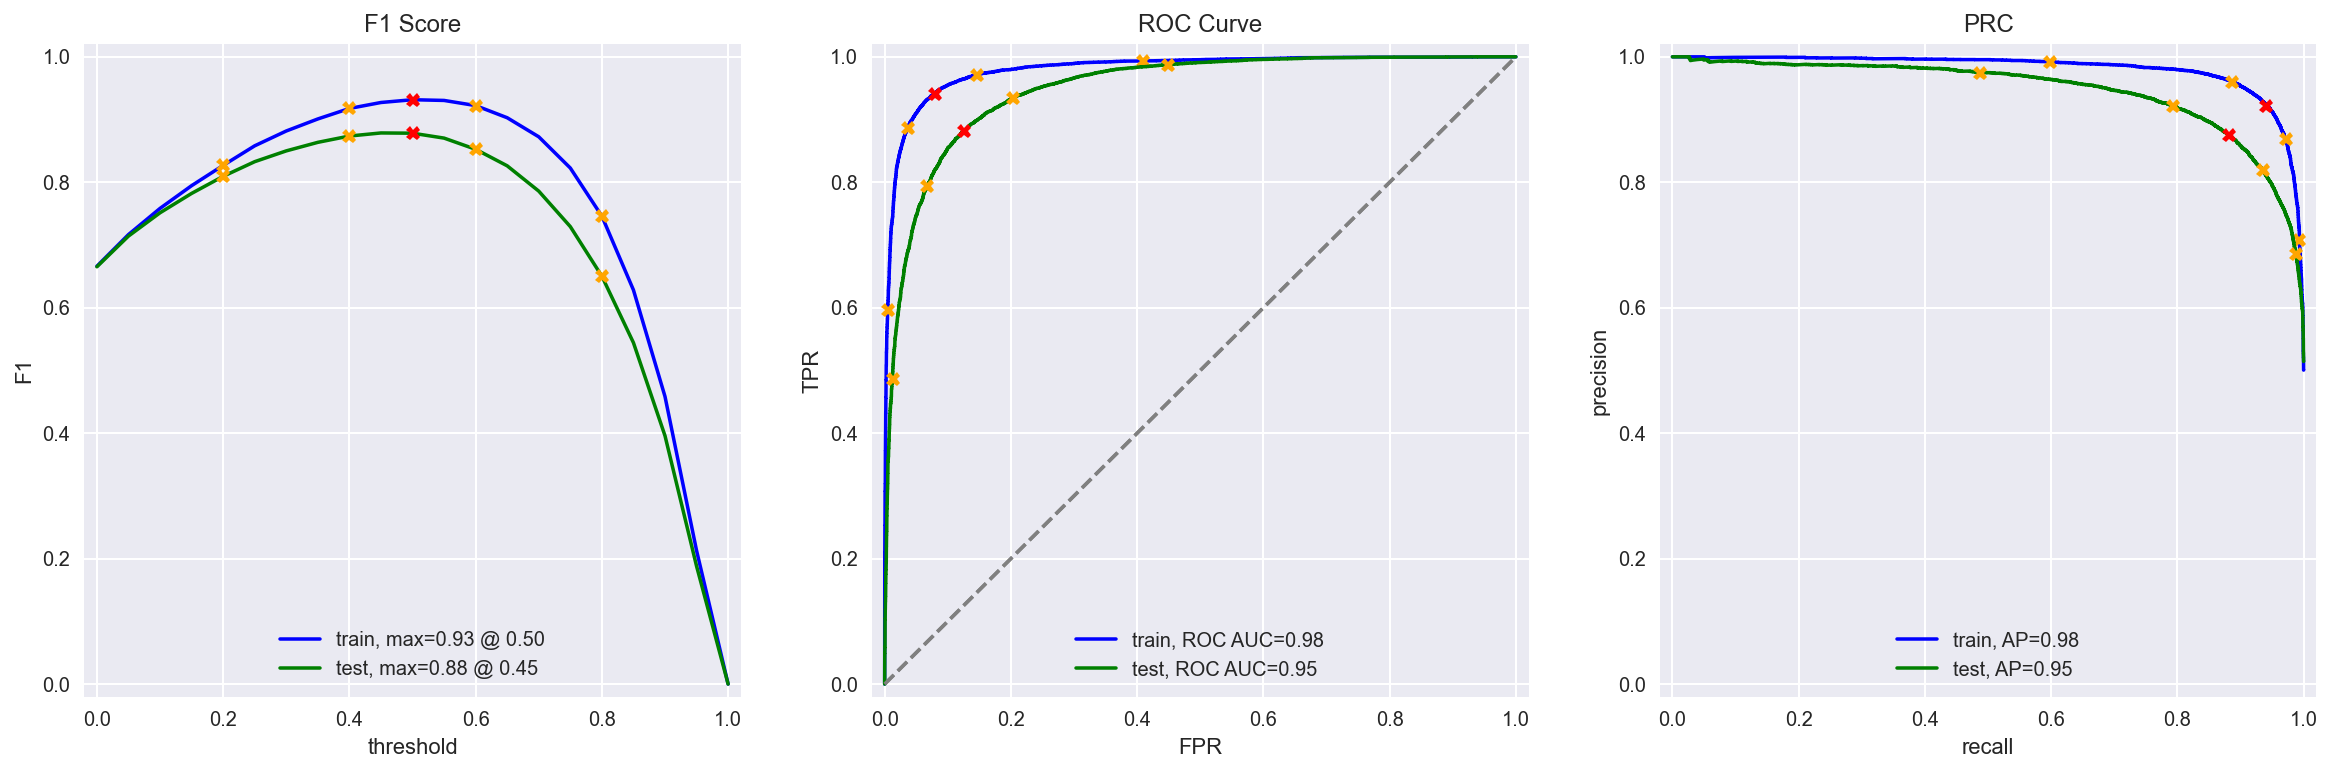

In [44]:
evaluate_model(model_2, tf_idf_train_nlp, train_target, tf_idf_test_nlp, test_target)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [45]:
from lightgbm import LGBMClassifier

In [207]:
lgb_model = lgb.LGBMClassifier()


parameters = {
        'task' : ['predict'],
     'boosting': ['gbdt' ],
     'num_iterations': [180, 210,10  ],
    'num_leaves':[ 180,210, 10 ],
    'max_depth' :[ 180,210,10],
     
 }

gsearch_lgb = GridSearchCV(lgb_model, param_grid = parameters, verbose=10,cv=5,scoring = 'f1')
gsearch_lgb.fit(tf_idf_train_nlp, train_target)
 

print('best params')
print (gsearch_lgb.best_params_)
#preds_lgb_model = gsearch_lgb.predict(features_test)
#rmse_lgb = np.sqrt(mean_squared_error(target_test, preds_lgb_model))
#print(" RMSE: %f" % (rmse_lgb ))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5; 1/27] START boosting=gbdt, max_depth=180, num_iterations=180, num_leaves=180, task=predict
[CV 1/5; 1/27] END boosting=gbdt, max_depth=180, num_iterations=180, num_leaves=180, task=predict;, score=0.871 total time= 1.2min
[CV 2/5; 1/27] START boosting=gbdt, max_depth=180, num_iterations=180, num_leaves=180, task=predict
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV 2/5; 1/27] END boosting=gbdt, max_depth=180, num_iterations=180, num_leaves=180, task=predict;, score=0.860 total time= 1.2min
[CV 3/5; 1/27] START boosting=gbdt, max_depth=180, num_iterations=180, num_leaves=180, task=predict
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV 3/5; 1/27] END boosting=gbdt, max_depth=180, num_iterations=180, num_leaves=180, task=predict;, score=0.858 total time= 1.2min
[CV 4/5; 1/27] START boosting

In [46]:
lgb_model = lgb.LGBMClassifier( task = 'predict',boosting ='gbdt',num_iterations = 180 ,num_leaves =210,max_depth = 180)
lgb_model.fit(tf_idf_train_nlp, train_target)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


LGBMClassifier(boosting='gbdt', max_depth=180, num_iterations=180,
               num_leaves=210, task='predict')

          train  test
Accuracy    1.0  0.87
F1          1.0  0.87
APS         1.0  0.94
ROC AUC     1.0  0.94


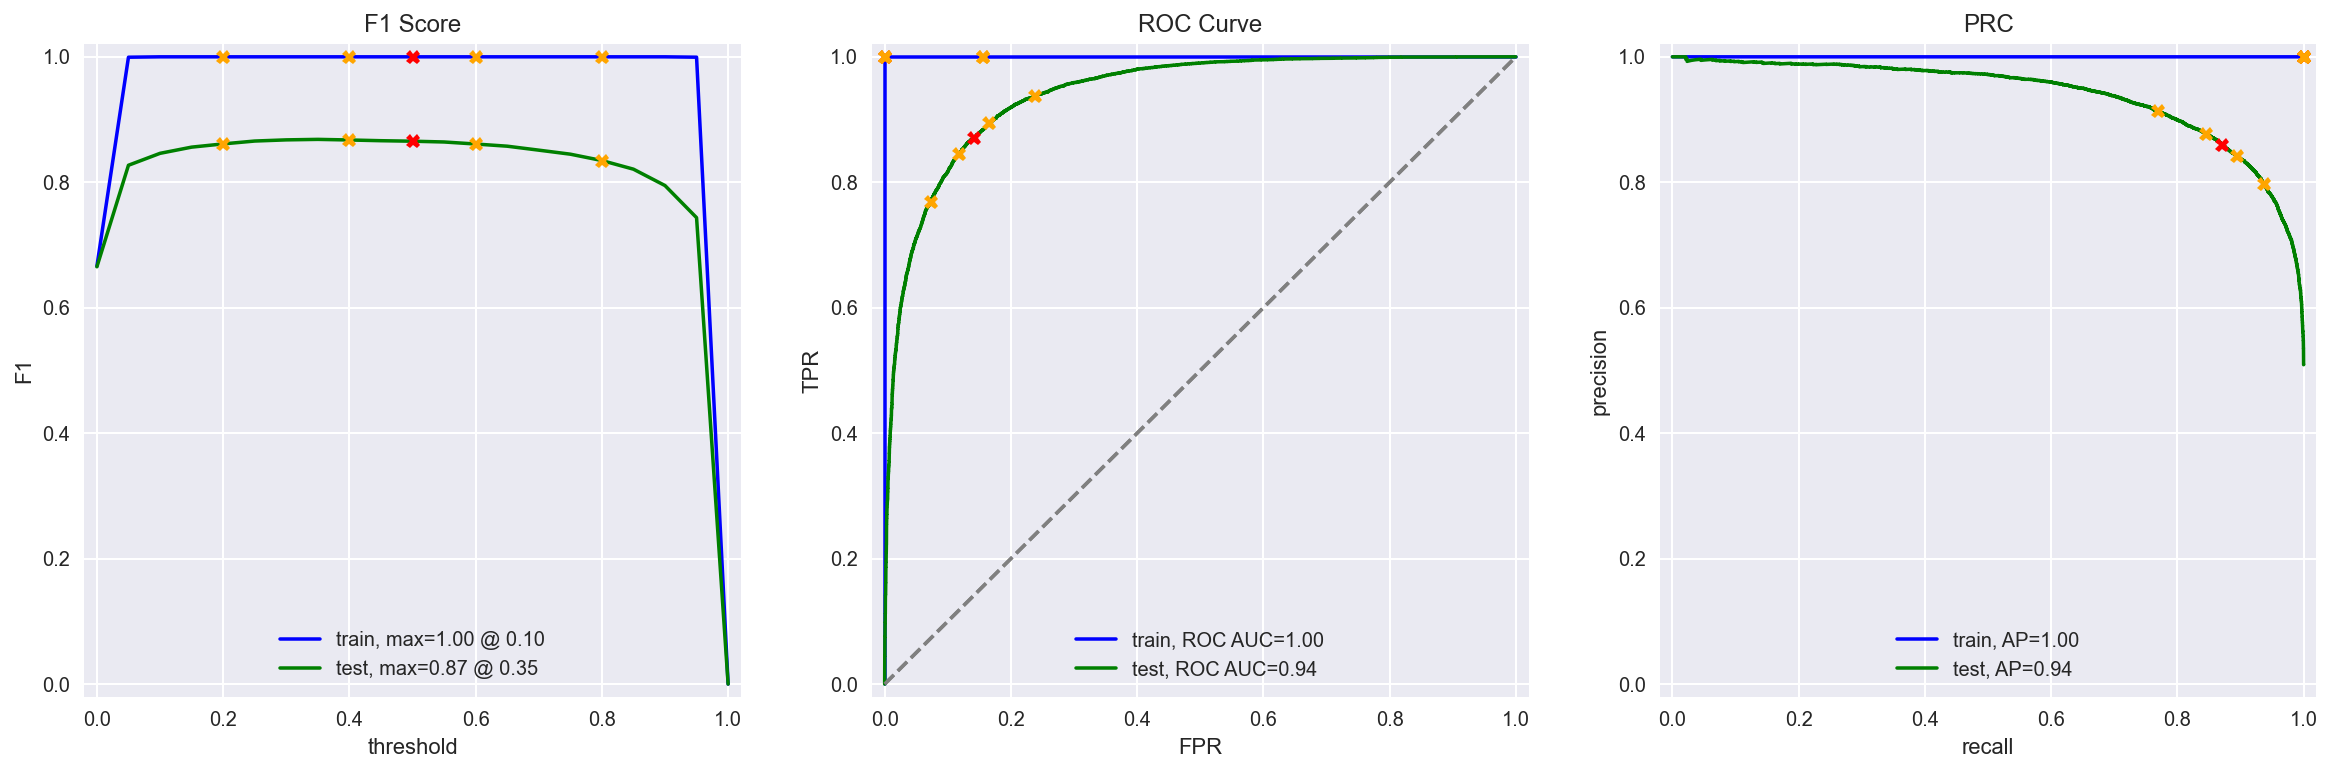

In [47]:
evaluate_model(lgb_model, tf_idf_train_nlp, train_target, tf_idf_test_nlp, test_target)

###  Model 9 - BERT

In [48]:
import torch
import transformers

In [49]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [119]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    
    # <put your code here to create ids_list and attention_mask_list>
    for input_text in texts:
        ids = tokenizer.encode(
            input_text.lower(),
            add_special_tokens=True,
            truncation=True,
            max_length=max_length,
        )
        padded = np.array(ids + [0] * (max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)

    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <put your code here to create attention_mask_batch

        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)

        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [120]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cpu')

Using the cpu device.


  0%|          | 0/238 [00:00<?, ?it/s]

In [126]:
test_test_9 = BERT_text_to_embeddings(df_reviews_test['review_norm'], force_device='cpu')

Using the cpu device.


  0%|          | 0/236 [00:00<?, ?it/s]

In [75]:
model.device

device(type='cuda', index=0)

In [121]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

(23796,)
(23796, 768)
(23796,)


In [129]:
print(df_reviews_train['review_norm'].shape)
print(test_test_9.shape)
print(test_target.shape)

(23796,)
(23533, 768)
(23533,)


In [128]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_test_9)

# and load...
with np.load('features_9.npz') as data:
    train_features_9 = data['train_features_9']
    test_features_9 = data['test_features_9']

In [130]:
model_bert_lgr = LogisticRegression(solver='liblinear',random_state=12345)

model_bert_lgr.fit(train_features_9, train_target)


LogisticRegression(random_state=12345, solver='liblinear')

          train  test
Accuracy   0.88  0.86
F1         0.88  0.86
APS        0.95  0.94
ROC AUC    0.95  0.94


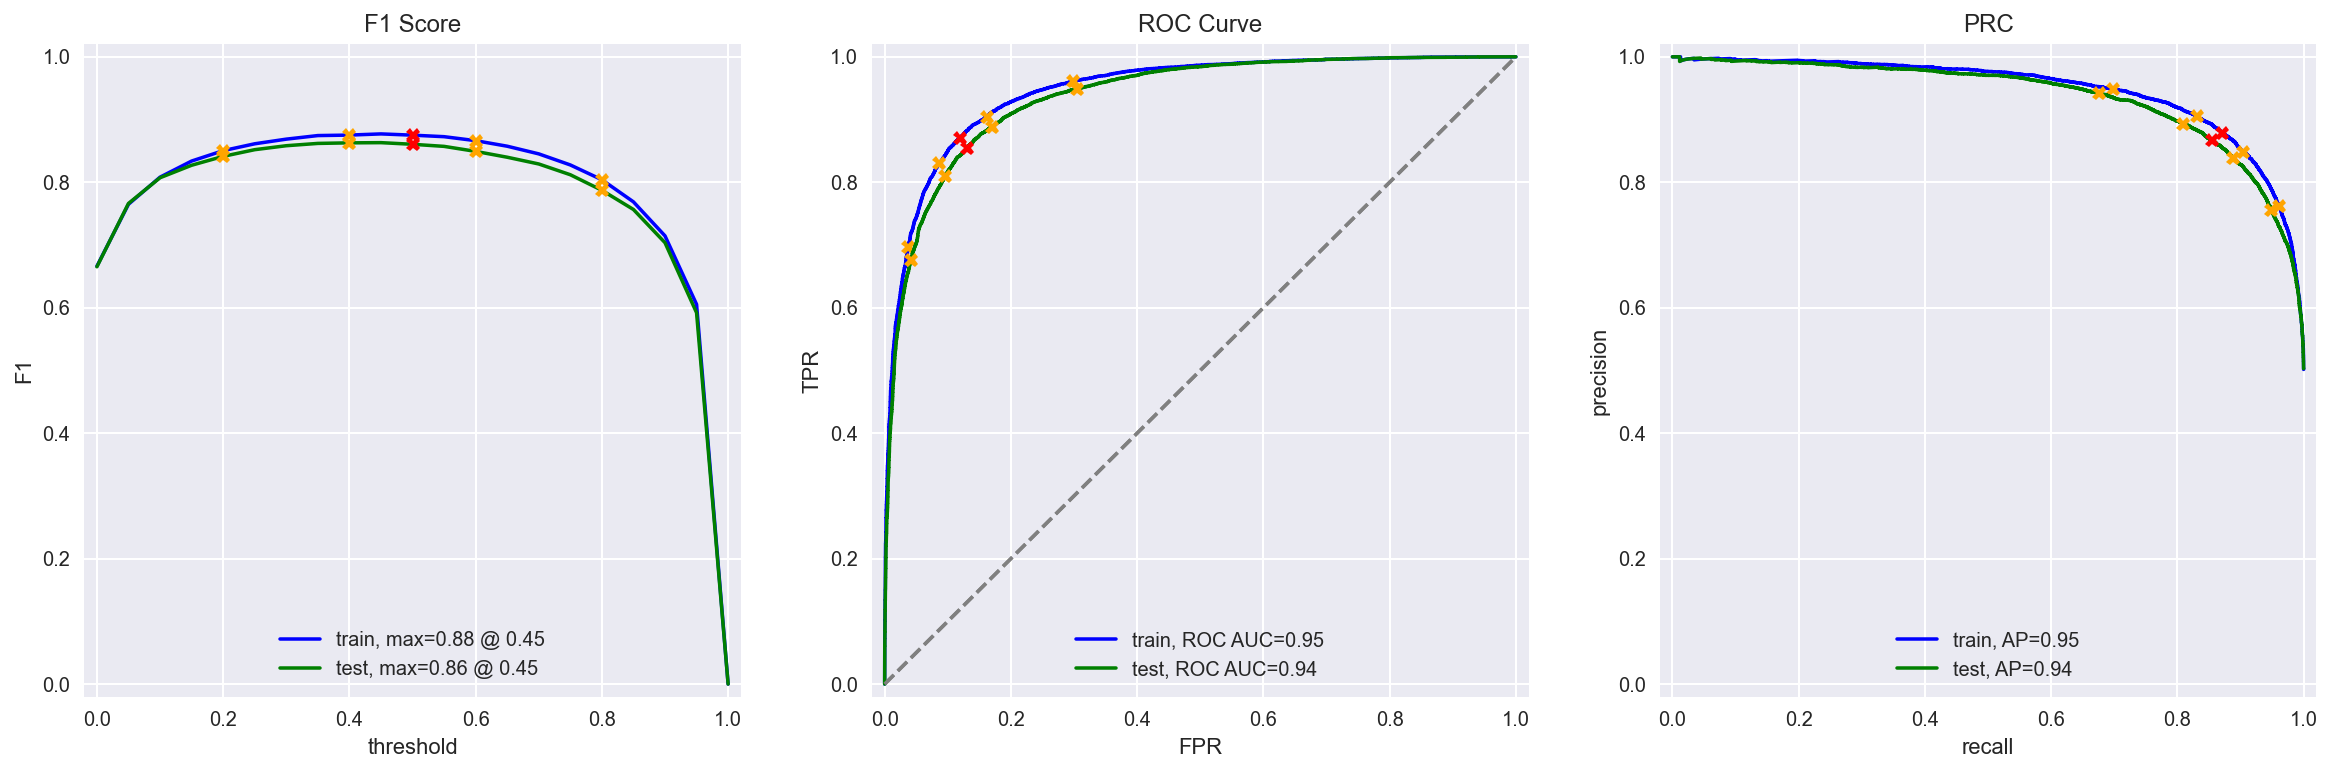

In [131]:
evaluate_model(model_bert_lgr,train_features_9, train_target, test_test_9, test_target)

<div style="border:solid black 2px; padding: 20px"> <b>Note:</b>
The most overfit model was the LGBMClassifier and the most underfit model is the BERT with LogisticRegression.

## My Reviews <a class="anchor" id="Reviews"></a> 

In [190]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.',
    'what an awful movie',
    'loved it so much',
    'These historical embroideries -- as well as an appealing, diverse cast -- might make for splendid cinema if only they weren’t trapped in a confused story line that starts as a revenge scheme before veering into romance.',  
    'Mr. Malcolm’s List is a delightful blend of modern romantic comedy and Jane Austen-esque nostalgia.'], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(clear_text)
my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn t expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...
8,what an awful movie,what an awful movie
9,loved it so much,loved it so much


### Model 2

In [191]:
nltk.download('stopwords') 
stop_words = set(stopwords.words('english')) 
count_vect = CountVectorizer(stop_words=stop_words) 
corpus_train = train_features

count_tf_idf = TfidfVectorizer(stop_words=stop_words) 

tf_idf_train = count_tf_idf.fit_transform(corpus_train) 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yaniv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [192]:
tfidf_vectorizer_2 = count_tf_idf.transform(my_reviews['review_norm']) 


In [193]:
tfidf_vectorizer_2.shape

(12, 71531)

In [194]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_2)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  i did not simply like it not my kind of movie
0.16:  well i was bored and felt asleep in the middle of the movie
0.54:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.31:  i didn t expect the reboot to be so good writers really cared about the source material
0.47:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.82:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
0.00:  what an awful movie
0.93:  loved it so much
0.49:  these historical embroideries as well as an appealing diverse cast might make for splendid cinema if
0.73:  mr malcolm s list is a delightful blend of modern romantic comedy and jane austen esque nostalgia


### Model 3

In [195]:
tf_idf_train_nlp = count_tf_idf.fit_transform(corpus_train_nlp)
texts = my_reviews['review_norm']
corpus_texts_nlp = texts.apply(text_preprocessing_3)
tfidf_vectorizer_3 =count_tf_idf.transform(corpus_texts_nlp)

In [196]:

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_3)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  i did not simply like it not my kind of movie
0.14:  well i was bored and felt asleep in the middle of the movie
0.49:  i was really fascinated with the movie
0.12:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.26:  i didn t expect the reboot to be so good writers really cared about the source material
0.51:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
0.00:  what an awful movie
0.92:  loved it so much
0.49:  these historical embroideries as well as an appealing diverse cast might make for splendid cinema if
0.75:  mr malcolm s list is a delightful blend of modern romantic comedy and jane austen esque nostalgia


### Model 4

In [197]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = lgb_model.predict_proba(tfidf_vectorizer_4)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.66:  i did not simply like it not my kind of movie
0.34:  well i was bored and felt asleep in the middle of the movie
0.77:  i was really fascinated with the movie
0.01:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.41:  i didn t expect the reboot to be so good writers really cared about the source material
0.98:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
1.00:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
0.00:  what an awful movie
0.86:  loved it so much
0.41:  these historical embroideries as well as an appealing diverse cast might make for splendid cinema if
0.97:  mr malcolm s list is a delightful blend of modern romantic comedy and jane austen esque nostalgia


### Model 9

In [198]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_bert_lgr.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.21:  i did not simply like it not my kind of movie
0.01:  well i was bored and felt asleep in the middle of the movie
0.99:  i was really fascinated with the movie
0.00:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.21:  i didn t expect the reboot to be so good writers really cared about the source material
0.94:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.09:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.96:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
0.15:  what an awful movie
1.00:  loved it so much
0.22:  these historical embroideries as well as an appealing diverse cast might make for splendid cinema if
0.96:  mr malcolm s list is a delightful blend of modern romantic comedy and jane austen esque nostalgia


## Conclusion <a class="anchor" id="Conclusion"></a>

Using different models to predict reviews can be complicated but yet good training can solve the problem with higher precision. the BERT model took me 8 hours to train on the CPU (the Cuda was out of memory), but it made the most precise model of them all, although with "my reviews" it classified one of the reviews as negative while it was positive. meaning it is the most precise but not 100 percent, and maybe using BERT with LGM or other models will make it more precise. 